# ENV setup




## check resouce

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Sep  1 02:01:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime > "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


## build Env

In [3]:
!ls -l

rootp = 'drive/MyDrive/Inductive_graph_representation/inductive_learning/'

from os import path
import sys
sys.path.append(path.abspath(rootp))

!pip install pyhocon 
!pip install dgl
!pip install python-igraph
!pip install powerlaw

total 8
drwx------ 5 root root 4096 Aug 31 23:20 drive
drwxr-xr-x 1 root root 4096 Aug 25 13:35 sample_data


# GraphSage

### Import packages

In [4]:
import sys
import os
import argparse

import numpy as np
from scipy.sparse import lil_matrix
import pickle
import random
import torch
import torch.nn.functional as F
import pyhocon
import dgl
import matplotlib.pyplot as plt

from scipy import sparse
from dgl.nn.pytorch import GraphConv as GraphConv

from src.dataCenter import *
from src.utils import *
from src.graphSage.models import *
import src.graphSage.runGSage as runGSage
import src.plotter as plotter
import src.graph_statistics as GS
import src.compare_gsageKdd_helper as helper
from src import classification

Using backend: pytorch


### parameter setup

In [5]:
parser = argparse.ArgumentParser(description='pytorch version of GraphSAGE')


parser.add_argument('--epochs', type=int, default=10)
parser.add_argument('--dataSet', type=str, default='DBLP')
parser.add_argument('--agg_func', type=str, default='MAX')
parser.add_argument('--b_sz', type=int, default=64)
parser.add_argument('--seed', type=int, default=123)
parser.add_argument('--cuda', action='store_true',
					help='use CUDA')
parser.add_argument('--gcn', action='store_true')
parser.add_argument('--learn_method', type=str, default='sup')
parser.add_argument('--unsup_loss', type=str, default='normal')
parser.add_argument('--lrate', type=float, default=0.1)
parser.add_argument('--max_vali_f1', type=float, default=0)
parser.add_argument('--name', type=str, default='debug')
parser.add_argument('--config', type=str, default='src/experiments.conf')

args_graphsage = parser.parse_args(args = ['--cuda'])
print("")
print("graphSage SETING: "+str(args_graphsage))


graphSage SETING: Namespace(agg_func='MAX', b_sz=64, config='src/experiments.conf', cuda=True, dataSet='DBLP', epochs=10, gcn=False, learn_method='sup', lrate=0.1, max_vali_f1=0, name='debug', seed=123, unsup_loss='normal')


### GPU check

In [6]:
if torch.cuda.is_available():
	if not args_graphsage.cuda:
		print("WARNING: You have a CUDA device, so you should probably run with --cuda")
	else:
		device_id = torch.cuda.current_device()
		print('using device', device_id, torch.cuda.get_device_name(device_id))

device = torch.device("cuda" if args_graphsage.cuda else "cpu")
print('DEVICE:', device)

using device 0 Tesla T4
DEVICE: cuda


### load data

In [7]:
#%% load config

random.seed(args_graphsage.seed)
np.random.seed(args_graphsage.seed)
torch.manual_seed(args_graphsage.seed)
torch.cuda.manual_seed_all(args_graphsage.seed)

# load config file
config = pyhocon.ConfigFactory.parse_file(rootp + args_graphsage.config)

#%% load data
ds = args_graphsage.dataSet
if ds == 'cora'or ds == 'IMDB' or ds == 'ACM' or ds == 'DBLP':
    dataCenter_sage = DataCenter(config)
    dataCenter_sage.load_dataSet(ds, "graphSage")
    features_sage = torch.FloatTensor(getattr(dataCenter_sage, ds+'_feats')).to(device)
    
else:
    dataCenter_kdd = DataCenter(config)
    dataCenter_kdd.load_dataSet(ds, "KDD")
    features_kdd = torch.FloatTensor(getattr(dataCenter_kdd, ds+'_feats')).to(device)

    dataCenter_sage = datasetConvert(dataCenter_kdd, ds)
    features_sage = features_kdd


18404 9203 3680 5521


In [8]:
embedding_type = ''  # replace

if embedding_type == 'concat':
  features =  getattr(dataCenter_sage, ds+'_feats')
  features = np.concatenate((features, np.zeros((len(features_sage), 128))), axis=1)
  print(features_sage.shape, features.shape)

  setattr(dataCenter_sage, ds + '_feats', features)
  features_sage = torch.FloatTensor(features).to(device)

In [9]:
adj = getattr(dataCenter_sage, ds + '_adj_matrix')
n_edge = sum(sum(adj))/2
print('Avg degree = ', n_edge / adj.shape[0])  

count = 0
train_set = getattr(dataCenter_sage, ds + '_train')
for row, col in zip(adj.nonzero()[0],adj.nonzero()[1]):
    if row in train_set and col in train_set:
        count += 1
count = count / 2
print('Avg degree_tr = ', count / adj.shape[0], count) 

Avg degree =  1.8453597044120844
Avg degree_tr =  0.5383068898065638 9907.0


In [10]:
print(adj.sum(axis = 0), adj.sum(axis = 1))
print('check Adj_matrix symmetric: ', sum(adj.sum(axis = 0) != adj.sum(axis = 1)))

[1.000e+00 1.000e+00 4.000e+00 ... 1.353e+03 1.471e+03 3.420e+02] [1.000e+00 1.000e+00 4.000e+00 ... 1.353e+03 1.471e+03 3.420e+02]
check Adj_matrix symmetric:  0


### train

In [11]:
# train graphsage
from models import *
graphSage, classification_sage, loss = runGSage.train_graphSage(dataCenter_sage, 
                                features_sage, args_graphsage,
                                config, device)

GraphSage with Supervised Learning

Begin to train the GraphSAGE:
----------------------EPOCH 0-----------------------
batch size =  64
node size after extending =  (1212,) , Num_negative =  20
Step [1/144], Loss: 1.4872, Dealed Nodes [1212/9203] 
batch size =  64
node size after extending =  (1132,) , Num_negative =  20
Step [2/144], Loss: 0.6196, Dealed Nodes [2194/9203] 
batch size =  64
node size after extending =  (1105,) , Num_negative =  20
Step [3/144], Loss: 0.4165, Dealed Nodes [2992/9203] 
batch size =  64
node size after extending =  (1095,) , Num_negative =  20
Step [4/144], Loss: 0.3774, Dealed Nodes [3729/9203] 
batch size =  64
node size after extending =  (1065,) , Num_negative =  20
Step [5/144], Loss: 0.3540, Dealed Nodes [4350/9203] 
batch size =  64
node size after extending =  (1010,) , Num_negative =  20
Step [6/144], Loss: 0.3361, Dealed Nodes [4882/9203] 
batch size =  64
node size after extending =  (1111,) , Num_negative =  20
Step [7/144], Loss: 0.3195, Deal

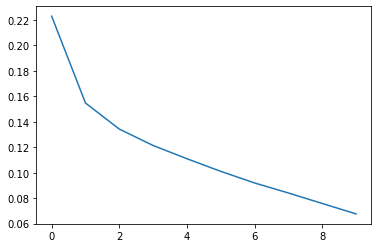

In [12]:
plt.plot(loss)

### Test

#### get embeddings 







In [13]:
trainId = getattr(dataCenter_sage, ds + '_train')
testValId = [i for i in range(len(features_sage)) if i not in trainId]
labels = getattr(dataCenter_sage, ds + '_labels')

# get training embedding
Z_sage_tr0 = runGSage.get_gnn_embeddings(graphSage, ds)[trainId].cpu().data

# load the complete adjacency matrix
runGSage.update_complete_adj(graphSage, dataCenter_sage, ds, device)



Loading embeddings from trained GraphSAGE model.
Embeddings loaded.
Updating training adjacency matrix with the complete adjacency matrix.


In [14]:
#%% get embedding of all nodes

if embedding_type == 'replace':
  features_new = getattr(dataCenter_sage, ds + '_feats')
  
  feat_ztr0 = np.zeros((len(trainId), len(features_new[0])))
  feat_ztr0[:, :len(Z_sage_tr0[0])] = Z_sage_tr0
  features_new[trainId, :] = feat_ztr0

  graphSage.raw_features = torch.FloatTensor(features_new).to(device)
elif embedding_type == 'concat':
  features_new = getattr(dataCenter_sage, ds + '_feats')
  features_new[trainId, -128:] = Z_sage_tr0
  print(features_new.shape)


  setattr(dataCenter_sage, ds + '_feats', features_new)
  graphSage.raw_features = torch.FloatTensor(features_new).to(device)


Z_sage = runGSage.get_gnn_embeddings(graphSage, ds).cpu().data
Z_sage_tr = Z_sage[trainId]
z_sage_te = Z_sage[testValId]

Loading embeddings from trained GraphSAGE model.
Embeddings loaded.


In [15]:
print((Z_sage_tr != Z_sage_tr0).sum(axis = 0))
print(((Z_sage_tr != Z_sage_tr0).sum(axis = 1)!= 0).sum(), 'out of ',len(Z_sage_tr))

tensor([ 567, 3189, 5240,  720, 6690, 7667, 9092, 7467,  353, 2320, 9082, 2331,
        7636, 7406, 9196, 1278, 7716, 3271, 9175, 9111, 7549, 3697,  171, 7337,
        7646, 1287, 7643, 3263, 2013,  307, 9161, 3482, 3887, 3238, 7290, 8250,
         229, 9188, 1467, 7731, 8244,  759, 7606, 3108, 9169, 8787, 7788,   57,
        3197,  548, 7982, 7660, 2812, 7907, 3483, 7548, 2586, 7649, 7615, 9080,
        2893, 7716, 7557, 1463, 9146,  872, 9190, 3444,  463,  565, 9045, 1661,
        9114, 3087, 9123, 7605, 1013, 1236, 7938, 7281, 9138, 6754, 1042, 3677,
         821, 9088, 7831, 6994,  272, 7518, 3539, 7237, 8250, 9074, 2459, 2101,
        3274, 2970, 1975, 7611, 3481, 2496, 2930, 3462, 7760, 7767, 2450, 7696,
         315, 1082, 4534,  158, 7442, 7475, 7659,  909, 5560, 8856, 7601, 9111,
         877, 1218,  362,   27, 7740,  139, 1142,   52])
tensor(9197) out of  9203


#### train classifier on $Z_{tr}^0$

In [16]:
# train classification/prediction model - NN
if args_graphsage.learn_method == 'unsup':
  print('Unsupervised learning ...')
  res_train_sage, classifier_sage = classification.NN_all(Z_sage_tr0, labels[trainId],
                        num_epochs = 300, batch_size = 64, learning_rate = 0.1)
  #res_train_sage, classifier_sage = classification.logistic_regression_all(Z_sage_tr0, labels[trainId])
elif args_graphsage.learn_method == 'sup':
  print('Supervised learning ...')
  classifier_sage = classification_sage.to('cpu')

  labels_pred_ztr0 = classifier_sage.predict(torch.Tensor(Z_sage_tr0))
  res_train_sage = classification.get_metrices(labels[trainId], labels_pred_ztr0.detach().numpy())

Supervised learning ...


In [17]:
Z_sage_tr0.shape

torch.Size([9203, 128])

##### evaluate

In [18]:
#%% ********************** TRAIN SET
print('\n# ****************** TRAIN SET ******************')
print('#  GraphSAGE')
print(res_train_sage[-1])

labels_pred_sage = classifier_sage.predict(torch.Tensor(Z_sage))

# ********************** TRAIN SET
print('\n# ****************** TRAIN SET ******************')
print('#  GraphSAGE')
helper.print_eval(labels[trainId], labels_pred_sage[trainId])

# ********************** TEST SET
print('\n# ****************** TEST SET ******************')
print('#  GraphSAGE')
helper.print_eval(labels[testValId], labels_pred_sage[testValId])


# ****************** TRAIN SET ******************
#  GraphSAGE
              precision    recall  f1-score   support

           0     0.9747    0.9292    0.9514      2033
           1     0.9801    0.9932    0.9866      7159
           2     1.0000    1.0000    1.0000        11

    accuracy                         0.9790      9203
   macro avg     0.9850    0.9741    0.9793      9203
weighted avg     0.9790    0.9790    0.9788      9203


# ****************** TRAIN SET ******************
#  GraphSAGE
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      2033
           1     1.0000    1.0000    1.0000      7159
           2     1.0000    1.0000    1.0000        11

    accuracy                         1.0000      9203
   macro avg     1.0000    1.0000    1.0000      9203
weighted avg     1.0000    1.0000    1.0000      9203


# ****************** TEST SET ******************
#  GraphSAGE
              precision    recall  f1-score   s

#### train on $Z_{tr}$

In [19]:
# train on Z_tr, then try again
if args_graphsage.learn_method == 'unsup':
    print('Unsupervised learning ...')
    res_train_sage, classifier_sage = classification.NN_all(Z_sage_tr, labels[trainId], 
                        num_epochs = 200, batch_size = 64, learning_rate = 0.1)

elif args_graphsage.learn_method == 'sup':
    classifier_sage, results = runGSage.train_classification_individually(Z_sage_tr, 
                            labels[trainId], learning_rate = 0.1, 
                            epochs = 100, b_sz = 64)

Training Classification ...
Epoch [1/100], Loss: 0.0171, Dealed Nodes [9203/9203] 
Epoch [2/100], Loss: 0.0008, Dealed Nodes [9203/9203] 
Epoch [3/100], Loss: 0.0005, Dealed Nodes [9203/9203] 
Epoch [4/100], Loss: 0.0004, Dealed Nodes [9203/9203] 
Epoch [5/100], Loss: 0.0003, Dealed Nodes [9203/9203] 
Epoch [6/100], Loss: 0.0003, Dealed Nodes [9203/9203] 
Epoch [7/100], Loss: 0.0003, Dealed Nodes [9203/9203] 
Epoch [8/100], Loss: 0.0003, Dealed Nodes [9203/9203] 
Epoch [9/100], Loss: 0.0002, Dealed Nodes [9203/9203] 
Epoch [10/100], Loss: 0.0002, Dealed Nodes [9203/9203] 
Epoch [11/100], Loss: 0.0002, Dealed Nodes [9203/9203] 
Epoch [12/100], Loss: 0.0002, Dealed Nodes [9203/9203] 
Epoch [13/100], Loss: 0.0002, Dealed Nodes [9203/9203] 
Epoch [14/100], Loss: 0.0002, Dealed Nodes [9203/9203] 
Epoch [15/100], Loss: 0.0002, Dealed Nodes [9203/9203] 
Epoch [16/100], Loss: 0.0002, Dealed Nodes [9203/9203] 
Epoch [17/100], Loss: 0.0002, Dealed Nodes [9203/9203] 
Epoch [18/100], Loss: 0.0002,

In [20]:

#%% ********************** TRAIN SET
print('\n# ****************** TRAIN SET ******************')
print('#  GraphSAGE')
helper.print_eval(labels[trainId], classifier_sage.predict(torch.Tensor(Z_sage_tr0)))

labels_pred_sage = classifier_sage.predict(torch.Tensor(Z_sage))

# ********************** TRAIN SET
print('\n# ****************** TRAIN SET ******************')
print('#  GraphSAGE')
helper.print_eval(labels[trainId], labels_pred_sage[trainId])

# ********************** TEST SET
print('\n# ****************** TEST SET ******************')
print('#  GraphSAGE')
helper.print_eval(labels[testValId], labels_pred_sage[testValId])


# ****************** TRAIN SET ******************
#  GraphSAGE
              precision    recall  f1-score   support

           0     0.9890    0.7073    0.8248      2033
           1     0.9326    0.9975    0.9640      7159
           2     0.1196    1.0000    0.2136        11

    accuracy                         0.9334      9203
   macro avg     0.6804    0.9016    0.6674      9203
weighted avg     0.9441    0.9334    0.9323      9203


# ****************** TRAIN SET ******************
#  GraphSAGE
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      2033
           1     1.0000    1.0000    1.0000      7159
           2     1.0000    1.0000    1.0000        11

    accuracy                         1.0000      9203
   macro avg     1.0000    1.0000    1.0000      9203
weighted avg     1.0000    1.0000    1.0000      9203


# ****************** TEST SET ******************
#  GraphSAGE
              precision    recall  f1-score   s

In [21]:
print(Z_sage_tr0[0])
print(Z_sage[tra])
print(t)

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.7980e-01, 1.0683e+00,
        6.8397e-01, 1.7156e+00, 0.0000e+00, 0.0000e+00, 5.6805e-01, 0.0000e+00,
        8.3146e-01, 1.1807e+00, 7.1528e+00, 0.0000e+00, 1.3495e+00, 0.0000e+00,
        1.3247e+00, 4.5460e+00, 1.6564e+00, 0.0000e+00, 0.0000e+00, 2.8105e+00,
        7.4896e+00, 0.0000e+00, 1.0807e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        3.0449e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.8871e+00, 1.1929e+01,
        0.0000e+00, 7.0472e+00, 0.0000e+00, 9.4379e+00, 6.2939e+00, 0.0000e+00,
        8.6700e+00, 0.0000e+00, 4.7932e+00, 1.3782e+00, 2.2316e+00, 0.0000e+00,
        8.2853e-02, 0.0000e+00, 1.2358e+01, 1.1836e+01, 0.0000e+00, 6.5043e+00,
        0.0000e+00, 4.1893e+00, 0.0000e+00, 1.0051e+01, 4.7665e+00, 2.0706e+00,
        0.0000e+00, 1.3846e+01, 8.6225e+00, 0.0000e+00, 5.1304e+00, 0.0000e+00,
        2.2972e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.8255e+00, 0.0000e+00,
        2.9655e-01, 0.0000e+00, 6.8477e-

NameError: ignored

# GraphSage & KDD Comparison

In [ ]:
import sys
import os
import argparse

import numpy as np
from scipy.sparse import lil_matrix
import pickle
import random
import torch
import torch.nn.functional as F
import pyhocon
import dgl

from scipy import sparse
from dgl.nn.pytorch import GraphConv as GraphConv

from src.dataCenter import *
from src.utils import *
from src.models import *
import src.plotter as plotter
import src.graph_statistics as GS
import src.compare_gsageKdd_helper as helper
from src import classification

## parameter setup

In [ ]:
parser = argparse.ArgumentParser(description='pytorch version of GraphSAGE')

parser.add_argument('--dataSet', type=str, default='cora')
parser.add_argument('--agg_func', type=str, default='MAX')
parser.add_argument('--epochs', type=int, default=3)
parser.add_argument('--b_sz', type=int, default=40)
parser.add_argument('--seed', type=int, default=123)
parser.add_argument('--cuda', action='store_false',
					help='use CUDA')
parser.add_argument('--gcn', action='store_true')
parser.add_argument('--learn_method', type=str, default='unsup')
parser.add_argument('--unsup_loss', type=str, default='normal')
parser.add_argument('--max_vali_f1', type=float, default=0)
parser.add_argument('--name', type=str, default='debug')
parser.add_argument('--config', type=str, default='./src/experiments.conf')

args_graphsage = parser.parse_args(args=[])

In [ ]:
parser = argparse.ArgumentParser(description='Inductive Interface')

parser.add_argument('--model', type=str, default='KDD')
parser.add_argument('--dataSet', type=str, default='cora')
parser.add_argument('--seed', type=int, default=123)
parser.add_argument('-num_node', dest="num_node", default=-1, type=str,
                    help="the size of subgraph which is sampled; -1 means use the whule graph")
parser.add_argument('--config', type=str, default='/Users/parmis/Desktop/parmis-thesis/related-work/codes/graphSAGE-pytorch-master/src/experiments.conf')
parser.add_argument('-decoder_type', dest="decoder_type", default="multi_inner_product",
                    help="the decoder type, Either SBM or InnerDot  or TransE or MapedInnerProduct_SBM or multi_inner_product and TransX or SBM_REL")
parser.add_argument('-encoder_type', dest="encoder_type", default="Multi_GCN",
                    help="the encoder type, Either ,mixture_of_GCNs, mixture_of_GatedGCNs , Multi_GCN or Edge_GCN ")
parser.add_argument('-f', dest="use_feature", default=True, help="either use features or identity matrix")
parser.add_argument('-NofRels', dest="num_of_relations", default=2,
                    help="Number of latent or known relation; number of deltas in SBM")
parser.add_argument('-NofCom', dest="num_of_comunities", default=128,
                    help="Number of comunites, tor latent space dimention; len(z)")
parser.add_argument('-BN', dest="batch_norm", default=True,
                    help="either use batch norm at decoder; only apply in multi relational decoders")
parser.add_argument('-DR', dest="DropOut_rate", default=.3, help="drop out rate")
parser.add_argument('-encoder_layers', dest="encoder_layers", default="128", type=str,
                    help="a list in which each element determine the size of gcn; Note: the last layer size is determine with -NofCom")
parser.add_argument('-lr', dest="lr", default=0.005, help="model learning rate")
parser.add_argument('-e', dest="epoch_number", default=100, help="Number of Epochs")
parser.add_argument('-NSR', dest="negative_sampling_rate", default=1,
                    help="the rate of negative samples which should be used in each epoch; by default negative sampling wont use")
parser.add_argument('-v', dest="Vis_step", default=50, help="model learning rate")
parser.add_argument('-modelpath', dest="mpath", default="VGAE_FrameWork_MODEL", type=str,
                    help="The pass to save the learned model")
parser.add_argument('-Split', dest="split_the_data_to_train_test", default=True,
                    help="either use features or identity matrix; for synthasis data default is False")
parser.add_argument('-s', dest="save_embeddings_to_file", default=True, help="save the latent vector of nodes")

args_kdd = parser.parse_args(args=[])
pltr = plotter.Plotter(functions=["Accuracy", "loss", "AUC"])



## GPU check

In [ ]:
if torch.cuda.is_available():
	if not args_graphsage.cuda:
		print("WARNING: You have a CUDA device, so you should probably run with --cuda")
	else:
		device_id = torch.cuda.current_device()
		print('using device', device_id, torch.cuda.get_device_name(device_id))

device = torch.device("cuda" if args_graphsage.cuda else "cpu")
print('DEVICE:', device)

## load data

In [ ]:

random.seed(args_graphsage.seed)
np.random.seed(args_graphsage.seed)
torch.manual_seed(args_graphsage.seed)
torch.cuda.manual_seed_all(args_graphsage.seed)

# load config file
config = pyhocon.ConfigFactory.parse_file(rootp + args_graphsage.config)

#%% load data
ds = args_graphsage.dataSet
if ds == 'cora':
    dataCenter_sage = DataCenter(config)
    dataCenter_sage.load_dataSet(ds, "graphSage")
    features_sage = torch.FloatTensor(getattr(dataCenter_sage, ds+'_feats')).to(device)
    
    dataCenter_kdd = DataCenter(config)
    dataCenter_kdd.load_dataSet(ds, "KDD")
    features_kdd = torch.FloatTensor(getattr(dataCenter_kdd, ds+'_feats')).to(device)
elif ds == 'IMDB' or ds == 'ACM':
    dataCenter_kdd = DataCenter(config)
    dataCenter_kdd.load_dataSet(ds, "KDD")
    features_kdd = torch.FloatTensor(getattr(dataCenter_kdd, ds+'_feats')).to(device)

    dataCenter_sage = datasetConvert(dataCenter_kdd, ds)
    features_sage = features_kdd

### compare datasets

In [ ]:
#%% compare two dataCenter

helper.check_equalDatacenter(dataCenter_sage, dataCenter_kdd, ds)


## Train

In [ ]:
from src.utils import * 

# train graphsage
from src.models import *

graphSage, classification_sage = helper.train_graphSage(dataCenter_sage, 
                              features_sage,args_graphsage,
                              config, device)


In [ ]:
# train inductive_kdd

from src.utils import *
inductive_kdd = helper.train_kddModel(dataCenter_kdd, features_kdd, args_kdd, device)


In [ ]:
inductive_kdd

## Test

### train classifier

In [ ]:
# add new nodes to the set
adj_sage = getattr(dataCenter_sage, ds+'_adj_lists')
feat = getattr(dataCenter_sage, ds+'_feats')
trainId = getattr(dataCenter_sage, ds+'_train')
testId = getattr(dataCenter_sage, ds + '_test')
valId = getattr(dataCenter_sage, ds+'_val')
labels = getattr(dataCenter_sage, ds+'_labels')

# + 5
d = len(feat[0])
feat = np.append(feat, np.zeros((5, d)), axis=0)
labels = np.append(labels, [0,1,0,1,0])
for i in range(len(adj_sage), (len(adj_sage)+5)):
  testId = np.append(testId, [i])
  for j in np.random.randint(len(adj_sage), size=10):
    adj_sage[i].add(j)
    adj_sage[j].add(i)

print(len(adj_sage), testId.shape, labels.shape, feat.shape)

setattr(dataCenter_sage, ds+'_test', testId)
#setattr(dataCenter_sage, ds+'_train', trainId)
#setattr(dataCenter_sage, ds+'_val', valId)
setattr(dataCenter_sage, ds+'_feats', feat)
setattr(dataCenter_sage, ds+'_labels', labels)
setattr(dataCenter_sage, ds+'_adj_lists', adj_sage)

In [ ]:
embedding_sage = get_gnn_embeddings(graphSage, dataCenter_sage, ds).cpu().data

In [ ]:

# get embedding of GraphSAGE
embedding_sage = get_gnn_embeddings(graphSage, dataCenter_sage, ds).cpu().data

# get embedding of KDD
inductive_kdd.to('cpu')
graph_dgl = dgl.from_scipy(sparse.csr_matrix(getattr(dataCenter_kdd, ds+'_adj_lists')))
graph_dgl.add_edges(graph_dgl.nodes(), graph_dgl.nodes())  # the library does not add self-loops
std_z, m_z, z, reconstructed_adj = inductive_kdd(graph_dgl, features_kdd.to('cpu'))
embedding_kdd = z.detach().numpy()

# train classification/prediction model - NN
trainId = getattr(dataCenter_kdd, ds + '_train')
labels = getattr(dataCenter_kdd, ds + '_labels')
res_train_sage, classifier_sage = classification.NN_all(embedding_sage[trainId,:],labels[trainId])
res_train_kdd, classifier_kdd = classification.NN_all(embedding_kdd[trainId,:],labels[trainId])


In [ ]:
print(classifier_sage)
print(classifier_kdd)

### evaluate

In [ ]:

# ********************** TRAIN SET
print('\n# ****************** TRAIN SET ******************')
print('#  GraphSAGE')
print(res_train_sage[-1])
print('#  KDD Model')
print(res_train_kdd[-1])


labels_pred_sage = classifier_sage.predict(torch.Tensor(embedding_sage))
labels_pred_kdd = classifier_kdd.predict(torch.Tensor(embedding_kdd))

# ********************** TEST SET
print('\n# ****************** TEST SET ******************')
testId = [i for i in range(len(labels)) if i not in trainId]
print('#  GraphSAGE')
helper.print_eval(labels[testId], labels_pred_sage[testId])
print('#  KDD Model')
helper.print_eval(labels[testId], labels_pred_kdd[testId])

# ********************** WHOLE SET
print('\n# ****************** WHOLE SET ******************')
print('#  GraphSAGE')
helper.print_eval(labels, labels_pred_sage)
print('#  KDD Model')
helper.print_eval(labels, labels_pred_kdd)



In [ ]:
device

In [ ]:
!cat /var/log/colab-jupyter.log